https://youtu.be/VMj-3S1tku0?si=lAQv1ysckiOJMbpN

backpropagation, although popular in neural networks, is not specific to nn. it is significantly more general, and can be applied to more arbitrary expressions.\
we're going to be working with scalars, but mathematically this is exactly same with tensors. we're only doing this for efficiency and simplicity.\
at the most fundamental level, we're going to need ~200 lines of simple python code to implement neural networks and train them using back-propagation. everything else that comes with added complexity is mainly for efficiency. 

In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def f(x):
    return 3*x**2 - 4*x + 5

In [51]:
f(5)

60

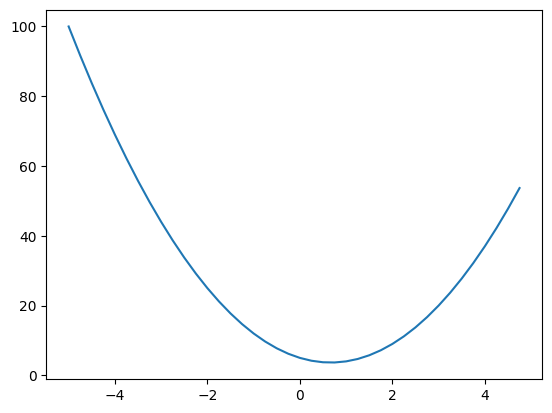

In [52]:
x = np.arange(-5,5, 0.25)
y = f(x)
plt.plot(x,y)

In [53]:
h = 10**-6
x = 3
(f(x+h)-f(x))/h

14.000003002223593

In [54]:
# complicating this further
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [55]:
# inputs 
a = 2
b = -3
c = 10
d1 = a*b + c
# d(d)/d(a)
a+=h
d2 = a*b + c

print(d1,d2, (d2-d1)/h)


4 3.9999969999999996 -3.000000000419334


In [140]:
class Value: 
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # why set? do we lose any info here?
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            # IMP - we do += here because we want to accumulate the gradients for a give Value, 
            # for ex. c=a+b and d=c+a i.e. d=(a+b)+a. in this case, the effect of change in Value a should be double on the output
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return -1 * self

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        # IMP
        assert isinstance(other, (int, float)) #otherwise, the derivative will be different
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self/other
        return self * other ** -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad 
        out._backward=_backward
        return out
    
    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    # imp
    def backward(self):
        topo = []
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()


In [139]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e=a*b
e.label='e'
d = e+c
d.label = 'd'
f = Value(-2, label = 'f')
L = d*f; L.label = 'L'
d, d._prev, d._op

(Value(data=4), {Value(data=-6), Value(data=10)}, '+')

In [58]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

# this follows DOT syntax
def draw_dot(root): 
    # direction: left -> right
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"{n.label} | data {n.data} | grad {n.grad}", shape='record')
        if n._op:
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

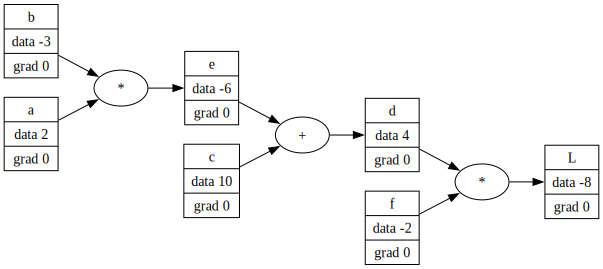

In [141]:
draw_dot(L)

Derivative at any point of the output w.r.t. the point (grad) tells us how changes in this value affects the output.

the lecture goes into the details of chain rule and backprop here.\
in short, + propagates the gradient as it is, * varies the gradient proportional to its coefficient

In [172]:
# tanh squashes the output

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

In [173]:
# IMP
o.grad = 1.0


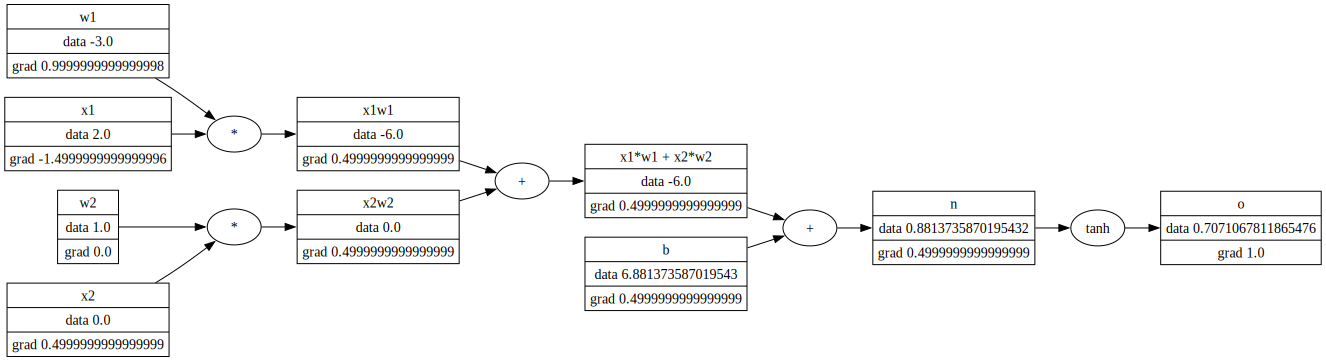

In [177]:
draw_dot(o)

In [77]:
o._backward()

In [79]:
n._backward()

In [81]:
b._backward()

In [82]:
x1w1x2w2._backward()

In [84]:
x2w2._backward()

In [85]:
x1w1._backward()

In [175]:
# topological sort implementation
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [176]:
for node in reversed(topo):
    node._backward()